# Dynamics for Aircraft Mission Performance

So, what we've demonstrated so far is great for problems where we care about the nitty-gritty of what's happening - we are directly simulating all flight dynamics modes.

For the quadcopter doing a flip, this is a good thing! The vehicle's dynamics have characteristic times that are on the same timescale as the maneuvers of interest, so we should just go ahead and simulate everything.

However, this is overly complex for most aircraft design problems. Most missions of interest are on the order of hours long, while most aircraft flight dynamics modes are on the order of seconds.

We can therefore make some simplifying assumptions:

* The vehicle's short-period modes are negligible, and all modes that don't affect the vehicle energy management (i.e., performance) can be discarded. (On an airplane with classical flight dynamics modes, this would mean that we would ignore all modes other than the phugoid mode.)
* This implies that the angular rates $p$, $q$, and $r$ are zero.
* All lateral modes can be ignored, as we assume that $\beta, \phi, p, r=0$.
* Because the short-period longitudinal mode is negligible and $q=0$, we assume $\theta$ can be prescribed - so $\theta$ is now a control variable, not a state variable.
* Our remaining state variables are $x_e, z_e, u, w$. We can re-parameterize this as $x_e, z_e, V, \gamma$ (where $V$ is the airspeed and $\gamma$ is the flight path angle) to reduce coupling.

Here, we can show what that looks like in practice.

## Optimal Gliding Problem

Let's say you're my Ph.D. advisor, John Hansman, and you're flying over central Massachusetts in your Cessna 152. All of a sudden, you hear your engine start to sputter - oh no.

In [17]:
thrust = 0

Let's determine:

1. Can he make it back to the airport?
2. What's the most energy-optimal trajectory to fly?

## Performance Estimation

To start, let's roughly define a vehicle geometry here, which we'll then use to estimate vehicle performance. (Both Geometry and Aerodynamics are covered in later tutorial sections.)

### Geometry Reconstruction

Geometry is roughly given by this three-view:

![threeview](./assets/cessna150.gif)

Which we can represent as:

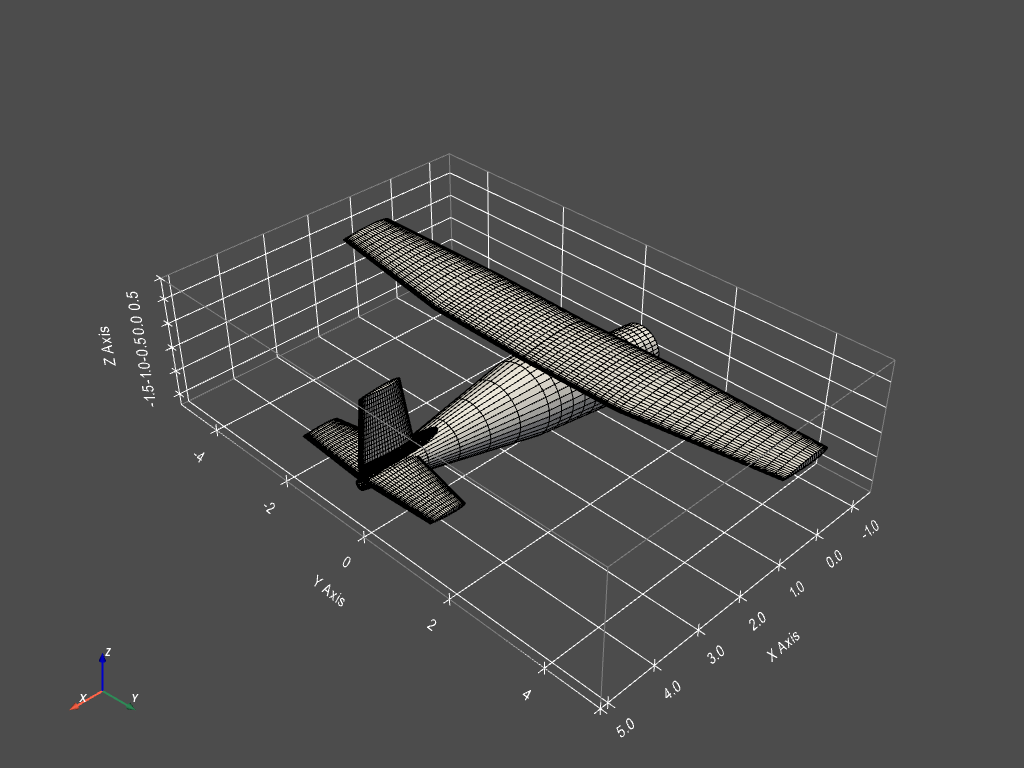

In [18]:
import aerosandbox as asb
import aerosandbox.numpy as np


def ft_to_m(feet, inches=0):  # Converts feet (and inches) to meters
    return 0.3048 * (feet + inches / 12)


naca2412 = asb.Airfoil("naca2412")
naca0012 = asb.Airfoil("naca0012")

naca2412.generate_polars(cache_filename="assets/naca2412.json")
naca0012.generate_polars(cache_filename="assets/naca0012.json")

airplane = asb.Airplane(
    name="Cessna 152",
    wings=[
        asb.Wing(
            name="Wing",
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=ft_to_m(5, 4),
                    airfoil=naca2412
                ),
                asb.WingXSec(
                    xyz_le=[0, ft_to_m(7), ft_to_m(7) * np.sind(1)],
                    chord=ft_to_m(5, 4),
                    airfoil=naca2412
                ),
                asb.WingXSec(
                    xyz_le=[
                        ft_to_m(4, 3 / 4) - ft_to_m(3, 8 + 1 / 2),
                        ft_to_m(33, 4) / 2,
                        ft_to_m(33, 4) / 2 * np.sind(1)
                    ],
                    chord=ft_to_m(3, 8 + 1 / 2),
                    airfoil=naca0012
                )
            ],
            symmetric=True
        ),
        asb.Wing(
            name="Horizontal Stabilizer",
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=ft_to_m(3, 8),
                    airfoil=naca0012,
                    twist=-2
                ),
                asb.WingXSec(
                    xyz_le=[ft_to_m(1), ft_to_m(10) / 2, 0],
                    chord=ft_to_m(2, 4 + 3 / 8),
                    airfoil=naca0012,
                    twist=-2
                )
            ],
            symmetric=True
        ).translate([ft_to_m(13, 3), 0, ft_to_m(-2)]),
        asb.Wing(
            name="Vertical Stabilizer",
            xsecs=[
                asb.WingXSec(
                    xyz_le=[ft_to_m(-5), 0, 0],
                    chord=ft_to_m(8, 8),
                    airfoil=naca0012,
                ),
                asb.WingXSec(
                    xyz_le=[ft_to_m(0), 0, ft_to_m(1)],
                    chord=ft_to_m(3, 8),
                    airfoil=naca0012,
                ),
                asb.WingXSec(
                    xyz_le=[ft_to_m(0, 8), 0, ft_to_m(5)],
                    chord=ft_to_m(2, 8),
                    airfoil=naca0012,
                ),
            ]
        ).translate([ft_to_m(16, 11) - ft_to_m(3, 8), 0, ft_to_m(-2)])
    ],
    fuselages=[
        asb.Fuselage(
            xsecs=[
                asb.FuselageXSec(
                    xyz_c=[0, 0, ft_to_m(-1)],
                    radius=0,
                ),
                asb.FuselageXSec(
                    xyz_c=[0, 0, ft_to_m(-1)],
                    radius=ft_to_m(1.5)
                ),
                asb.FuselageXSec(
                    xyz_c=[ft_to_m(3), 0, ft_to_m(-0.85)],
                    radius=ft_to_m(1.7)
                ),
                asb.FuselageXSec(
                    xyz_c=[ft_to_m(5), 0, ft_to_m(0)],
                    radius=ft_to_m(2.7)
                ),
                asb.FuselageXSec(
                    xyz_c=[ft_to_m(10, 4), 0, ft_to_m(0.3)],
                    radius=ft_to_m(2.3)
                ),
                asb.FuselageXSec(
                    xyz_c=[ft_to_m(21, 11), 0, ft_to_m(0.8)],
                    radius=ft_to_m(0.3)
                ),
            ]
        ).translate([ft_to_m(-5), 0, ft_to_m(-3)])
    ]
)

mesh = airplane.draw(show=False)
import pyvista as pv

p = pv.Plotter()
p.add_mesh(mesh, show_edges=True)
p.add_axes()
p.add_bounding_box()
p.renderer.show_grid()
# p.camera.enable_parallel_projection()
# p.camera_position='xz'
# p.camera.zoom(2)
if '__file__' not in locals():
    p.show(jupyter_backend="static")


### Aerodynamic Performance Estimation

We can then use our geometry to estimate polars:

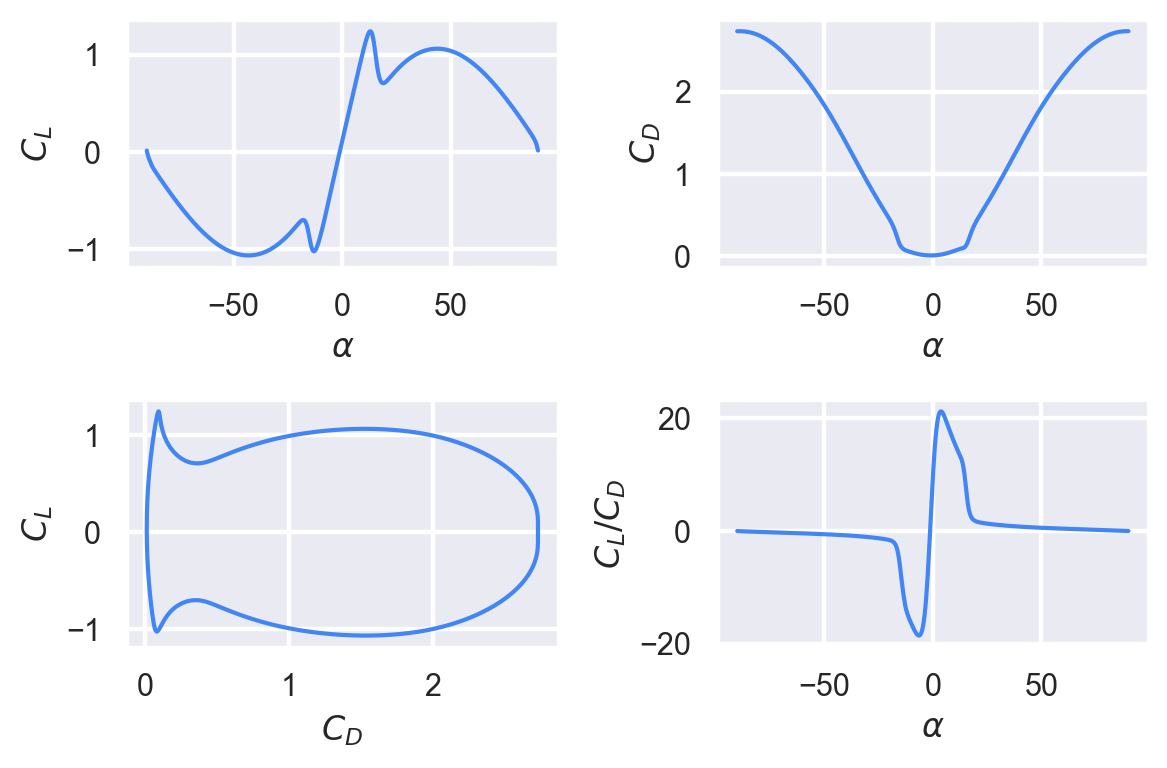

In [19]:
alpha = np.linspace(-90, 90, 500)
aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=107 * 0.514444,  # knots to m/s,
        alpha=alpha,
    )
).run()

from aerosandbox.tools.pretty_plots import plt, show_plot

fig, ax = plt.subplots(2, 2)
plt.sca(ax[0, 0])
plt.plot(alpha, aero["CL"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_L$")

plt.sca(ax[0, 1])
plt.plot(alpha, aero["CD"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_D$")

plt.sca(ax[1, 0])
plt.plot(aero["CD"], aero["CL"])
plt.xlabel(r"$C_D$")
plt.ylabel(r"$C_L$")

plt.sca(ax[1, 1])
plt.plot(alpha, aero["CL"] / aero["CD"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_L/C_D$")

show_plot()

In [20]:
from aerosandbox.tools.pretty_plots import plt, show_plot, mpl, adjust_lightness


class AirplaneDynamics(asb.FreeBodyDynamics):
    pass

AttributeError: module 'aerosandbox' has no attribute 'FreeBodyDynamics'